In [17]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [ ]:
class AgentState(TypedDict):
    topic: str
    report: str
    summary: str

In [26]:
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.3)

In [27]:
summarize_research_prompt = """
"""

In [ ]:
@tool
def research(topic: str, limit: int, time_frame: str) -> list:
    """
    This tool will do research about any given topics,
    it will do websearch using firecrawl search and scrape data,
    it will then create a detailed report and return as a string


    Args:
        topic: Name or context of topic to research about max 100 chars
        limit: result limit
        time_frame: freshness // qdr:h - Past hour, qdr:d - Past 24 hours, qdr:w - Past week, qdr:m - Past month, qdr:y - Past year
    """
    from firecrawl import FirecrawlApp, ScrapeOptions
    app = FirecrawlApp(api_key="fc-YOUR_API_KEY")
    search_result = app.search(
        topic, 
        limit=limit,
        scrape_options=ScrapeOptions(formats=["markdown"]),
        tbs=time_frame
    )

    return search_result.data


@tool
def summarize_research(research_data: str) -> str:
    """
    After successfully getting report topic from research tool,
    this tool will help it summuarize the entire report and explain out in simpler term for user.

    Args:
        research_data: Entire report, to generate the summary
    """
    local_llm_node = ChatOpenAI(model="gpt-4o-mini")

    user_message = HumanMessage(content=research_data)
    msg = [summarize_research_prompt] + ['\n\n' + user_message]

    prompt = SystemMessage(content=msg)

    response = local_llm_node.invoke(prompt)

    return response.content


def save(paper: str) -> str:
    """Determine if we should save or discard the report."""

    save = input(" 🧠 AI : Do you want to save the report? (Y/n)").strip().lower()

    if save == 'y':
        pass
    else:
        pass

    return 'success'

@tool
def output_display(state: AgentState) -> AgentState:
    """
    After getting summary of report it will display the summary to user

    Args:
        state: entire node state 
    """
    
    save(state['report'])
    save(state['summary'])

    return state

In [14]:
tools = [research, summarize_research, output_display]
llm.bind_tools(tools=tools)

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7b5b48435460>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7b5b48405430>, root_client=<openai.OpenAI object at 0x7b5b484315b0>, root_async_client=<openai.AsyncOpenAI object at 0x7b5b480d7b90>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'research', 'description': 'This tool will do research about any given topics,\nit will do websearch using firecrawl search and scrape data,\nit will then create a detailed report and return as a string', 'parameters': {'properties': {'topic': {'type': 'string'}}, 'required': ['topic'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'summarize_research', 'description': 'After successfully getting report topic from research tool,\nthis tool will help it summuarize the en

In [ ]:
def init_node(state: AgentState) -> AgentState:
    """Initially Ask about search topic"""

    # research_topic = input(" 🧠 AI : Please inseart the topic you want to research about : ").strip().lower()
    research_topic = 'AI agent'

    if research_topic == 'exit' or research_topic == 'quit' or research_topic == "":
        import sys
        sys.exit(0)

    state['topic'] = research_topic

    return state

system_prompt = """
"""

enhancement_prompt = """
"""

def prompt_enhancer(state: AgentState) -> AgentState:
    """This AI node is used for prompt enhancement"""

    llm_node = ChatOpenAI(model='gpt-4o-mini', temperature=0.5)

    user_message = HumanMessage(content=state['topic'])
    prompt = [enhancement_prompt] + ['\n\n' + user_message]
    response = llm_node.invoke(prompt)

    state['topic'] = response.content

    return state


def agent(state: AgentState) -> AgentState:
    """AI Agent to deeply run research about"""
    
    message = [system_prompt] + ["\n\n Research Topic:\n" + state['topic']]

    response = llm.invoke(message)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return state


def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")

In [22]:
graph = StateGraph(AgentState)
graph.add_node("init_node", init_node)
graph.add_node("prompt_enhancer", prompt_enhancer)
graph.add_node("agent", agent)

graph.add_edge(START, "init_node")
graph.add_edge("init_node", "prompt_enhancer")
graph.add_edge("prompt_enhancer", "agent")
graph.add_edge('agent', END)

app = graph.compile()

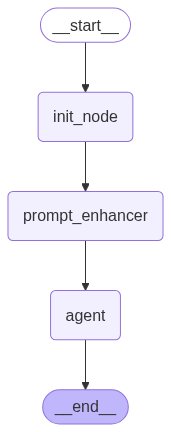

In [23]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def run_researcher_agent():
    print("\n ===== RESEARCHER =====")
    state = {"topic": '', "report": '', 'summary': ''}
    app.invoke(state)
    print("\n ===== RESEARCHER FINISHED =====")

if __name__ == "__main__":
    run_researcher_agent()